# Code for k-means and ETC distance

In [1]:
using Random
using StatsBase
using Plots
using LinearAlgebra
using SparseArrays
using BenchmarkTools

In [2]:
"""
Naive implementation of k-means clustering. 

# Inputs
+ `data`: A matrix where each row is a node
+ `k`: number of clusters 

# Output
+ `centers`: A matrix with `k` rows, each row is an estimated cluster center
+ `clusters`: Vector of integer vectors. `clusters[1]` stores cluster 1's members, and so on
"""
function kmeans(data::Matrix{Float64}, k::Int)
    dim   = size(data, 2)            # number of dimension for each data
    nodes = size(data, 1)            # total number of data points
    centers  = randn(k, dim)         # randomly initialize k cluster centers
    clusters = [Int[] for i in 1:k]  # vector storing each cluster's nodes
    new_center = zeros(dim)          # preallocated vector for efficiency
    
    # run 10 iterations of k-means
    for iter in 1:10
        
        # assign each node to the nearest cluster
        empty!.(clusters) # refresh cluster members
        for i in 1:nodes
            best_dist = Inf
            destin = 0
            for j in 1:k
                dist = euclidean(data, centers, i, j) # euclidean(data[i, :], centers[j, :]))
                if dist < best_dist
                    destin = j
                    best_dist = dist
                end
            end
            push!(clusters[destin], i)
        end
        
        # update cluster centers by computing mean of each cluster
        for c in 1:k
            fill!(new_center, 0.0) 
            # loop through each node in cluster
            for i in 1:length(clusters[c])
                node = clusters[c][i]
                for j in 1:length(new_center)
                    new_center[j] += data[node, j]
                end
            end
            new_center ./= length(clusters[c])
            for i in 1:dim
                centers[c, i] = new_center[i]
            end
        end
    end
    
    return centers, clusters
end

"""
Calculates euclidean distance between `data1[i, :]` and `data[j, :]` 
without memory allocation.
"""
function euclidean(data1::Matrix, data2::Matrix, i::Int, j::Int)
    d = 0.0
    for col in 1:size(data1, 2)
        d += (data1[i, col] - data2[j, col])^2 
    end
    return sqrt(d)
end

euclidean

In [3]:
"""
Calculates adjacency matrix from data. For node i, find h nodes closest 
to it by Euclidean distance, and weight will be inverse of that. 

# Input
+ `data`: A matrix where each row is a node
+ `h`: number of connections each node will form with its neighbor
"""
function adj_matrix(data::AbstractMatrix, h::Int)
    n = size(data, 1)
    A = zeros(n, n)
    d = zeros(n)
    for i in 1:n
        for j in 1:n
            d[j] = euclidean(data, data, i, j) # euclidean(data[i, :], data[j, :]))
        end
        d[i] = Inf # no self edges
        
        # find h nodes closest to node i and assign inverse euclidean weight
        radius = partialsort(d, h)
        for j in 1:n
            if d[j] <= radius
                A[j, i] = 1 / d[j]
            end
        end
    end
    
    # TODO: add minimum spanning tree instead of connecting node i to i+1 
    for i in 1:(n - 1)
        if i == Int(n/2)
            continue # don't connect 2 clusters using random 2 nodes
        end
        A[i, i + 1] = A[i + 1, i] = euclidean(data, data, i, i + 1)
    end
    A[n - 1, n] = A[n, n - 1] = euclidean(data, data, n, n - 1)
    
    return A
end

function prob_matrix(A::AbstractMatrix)
    rowsum = sum(A, dims=2)
    return sparse(A ./ sum(A, dims=2))
end

function laplacian_matrix(A::AbstractMatrix)
    rowsum = sum(A, dims=2)
    return Diagonal(vec(rowsum)) - A
end

function pseudo_L(L::AbstractMatrix)
    n = size(L, 1)
    return inv(L .- (1 / n)) .+ (1 / n)
end

# M: average first passage time matrix, iteratively estimated
function fpt_matrix(P::AbstractMatrix)
    n = size(P, 1)
    M = zeros(n, n)
    store = zeros(n, n)
    for i in 1:100
        mul!(store, P, M)
        store .+= 1.0
        for j in 1:n
            store[j, j] = 0.0
        end
        copyto!(M, store)
    end
    return M
end

function etc_distance(Vg::Float64, pseudo_L::AbstractMatrix, i::Int, j::Int)
    if i == j
        return 0.0 
    end
    
    n = size(pseudo_L, 1)
    v = spzeros(n)
    v[i] = 1.0
    v[j] = -1.0
    return (Vg * (v' * (pseudo_L * v)))^2
end

function etc_distance_fast(M::AbstractMatrix, i::Int, j::Int)
    return (M[i, j] + M[j, i])^2
end

etc_distance_fast (generic function with 1 method)

In [4]:
function kmeans_etc(data::Matrix{Float64}, k::Int)
    dim   = size(data, 2)                        # number of dimension for each data
    nodes = size(data, 1)                        # total number of data points
    centers  = sample(1:nodes, k, replace=false) # randomly choose k nodes to be centers
    clusters = [Int[] for i in 1:k]              # vector storing each cluster's nodes
    
    # compute essential quantities
    A  = adj_matrix(data, 3)
    L  = laplacian_matrix(A)
    Vg = sum(A)
    L_pseudo = pseudo_L(L)
    J = Inf # within-cluster variance, used to track convergence

    # run maximum 100 iterations of k-means using euclidean commute time distance
    for iter in 1:100
        
        # assign each node to the nearest cluster
        empty!.(clusters) # refresh cluster members
        for i in 1:nodes
            best_dist = Inf
            destin = 0
            for j in 1:k
                dist = etc_distance(Vg, L_pseudo, i, centers[j])
                if dist <= best_dist
                    destin = j
                    best_dist = dist
                end
            end
            push!(clusters[destin], i)
        end
                
        # update cluster centers by finding most central node within cluster
        J_new = 0.0
        for c in 1:k
            cluster_error = Inf
            # loop through each node in cluster
            for i in 1:length(clusters[c])
                node = clusters[c][i]
                err  = 0.0
                for j in 1:length(clusters[c])
                    err += etc_distance(Vg, L_pseudo, node, j)
                end
                if err < cluster_error
                    centers[c] = node
                    cluster_error = err
                end
            end
            J_new += cluster_error
        end
        
        # check convergence
        if J - J_new < 0.0001
            break
        else
            J = J_new
        end
    end
    
    return centers, clusters, J
end

kmeans_etc (generic function with 1 method)

In [5]:
function kmeans_etc_fast(data::Matrix{Float64}, k::Int)
    dim   = size(data, 2)                        # number of dimension for each data
    nodes = size(data, 1)                        # total number of data points
    centers  = sample(1:nodes, k, replace=false) # randomly choose k nodes to be centers
    clusters = [Int[] for i in 1:k]              # vector storing each cluster's nodes
    
    # compute essential quantities
    A = adj_matrix(data, 3)
    P = prob_matrix(A)
    M = fpt_matrix(P)
    J = Inf # within-cluster variance, used to track convergence
    
    # run maximum 100 iterations of k-means using euclidean commute time distance
    for iter in 1:100
        
        # assign each node to the nearest cluster
        empty!.(clusters) # refresh cluster members
        for i in 1:nodes
            best_dist = Inf
            destin = 0
            for j in 1:k
                dist = etc_distance_fast(M, i, centers[j])
                if dist <= best_dist
                    destin = j
                    best_dist = dist
                end
            end
            push!(clusters[destin], i)
        end
                
        # update cluster centers by finding most central node within cluster
        J_new = 0.0
        for c in 1:k
            cluster_error = Inf
            # loop through each node in cluster
            for i in 1:length(clusters[c])
                node = clusters[c][i]
                err  = 0.0
                for j in 1:length(clusters[c])
                    err += etc_distance_fast(M, node, j)
                end
                if err < cluster_error
                    centers[c] = node
                    cluster_error = err
                end
            end
            J_new += cluster_error
        end
        
        # check convergence
        if J - J_new < 0.0001
            break
        else
            J = J_new
        end
    end
    
    return centers, clusters, J
end

kmeans_etc_fast (generic function with 1 method)

## Simulation 1

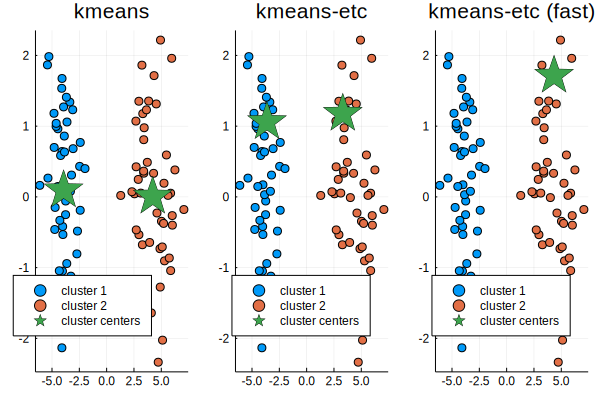

In [21]:
Random.seed!(203)
n = 100

# simulate 2 Gaussian clusters, 1 with mean -4 another with mean +4
data = randn(n, 2)
data[1:Int(n/2), 1] .-= 4
data[Int(n/2) + 1:end, 1] .+= 4
scatter(data[:, 1], data[:, 2], label="data")

# run traditional k-means
centers, clusters = kmeans(data, 2)
plot1 = scatter(data[clusters[1], 1], data[clusters[1], 2], label="cluster 1", title="kmeans", legend=:bottom)
scatter!(plot1, data[clusters[2], 1], data[clusters[2], 2], label="cluster 2")
scatter!(plot1, centers[:, 1], centers[:, 2], label="cluster centers", markersize=20, markershape=:star5)

# run ETC distance based k-mean 
centers, clusters, J = kmeans_etc(data, 2)
plot2 = scatter(data[clusters[1], 1], data[clusters[1], 2], label="cluster 1", title="kmeans-etc")
scatter!(plot2, data[clusters[2], 1], data[clusters[2], 2], label="cluster 2")
center_x = [data[centers[1], 1]; data[centers[2], 1]]
center_y = [data[centers[1], 2]; data[centers[2], 2]]
scatter!(plot2, center_x, center_y, label="cluster centers", 
    markersize=20, markershape=:star5, legend=:bottomright)

# run iterative (fast) ETC distance based k-mean 
centers, clusters, J = kmeans_etc_fast(data, 2)
plot3 = scatter(data[clusters[1], 1], data[clusters[1], 2], label="cluster 1", title="kmeans-etc (fast)")
scatter!(plot3, data[clusters[2], 1], data[clusters[2], 2], label="cluster 2")
center_x = [data[centers[1], 1]; data[centers[2], 1]]
center_y = [data[centers[1], 2]; data[centers[2], 2]]
scatter!(plot3, center_x, center_y, label="cluster centers", 
    markersize=20, markershape=:star5, legend=:bottomright)

merged_plots = plot(plot1, plot2, plot3, layout=(1, 3))
display(merged_plots)
savefig(merged_plots, "./figures/convex.png")

## Simulation 2

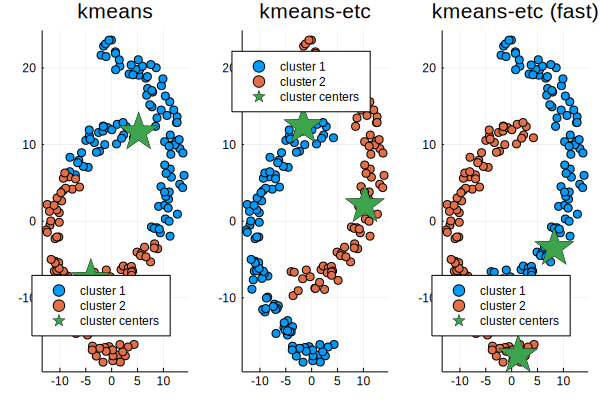

In [22]:
Random.seed!(203)

# make non-convex plot
r = 15;
x1c = [-5; 5]
x2c = [2; -5]
θ = collect(-π/2:0.03:π/2)
x1 = x1c[1] .+ r*cos.(θ)
y1 = x1c[2] .+ r*sin.(θ)
x2 = x2c[1] .+ r*cos.(θ .+ π)
y2 = x2c[2] .+ r*sin.(θ)
noise = 4
n = length(θ)
x1 = x1 + noise*rand(n)
y1 = y1 + noise*rand(n)
x2 = x2 + noise*rand(n)
y2 = y2 + noise*rand(n)
data = [[x1 y1]; [x2 y2]]
# scatter(data[:, 1], data[:, 2])

# run k-means and plot
centers, clusters = kmeans(data, 2)
plot1 = scatter(data[clusters[1], 1], data[clusters[1], 2], label="cluster 1", legend=:bottomright, title="kmeans")
scatter!(plot1, data[clusters[2], 1], data[clusters[2], 2], label="cluster 2")
scatter!(plot1, centers[:, 1], centers[:, 2], label="cluster centers", markersize=20, markershape=:star5)

# run ETC distance based k-mean 
centers, clusters, J = kmeans_etc(data, 2)
plot2 = scatter(data[clusters[1], 1], data[clusters[1], 2], label="cluster 1", title="kmeans-etc")
scatter!(plot2, data[clusters[2], 1], data[clusters[2], 2], label="cluster 2")
center_x = [data[centers[1], 1]; data[centers[2], 1]]
center_y = [data[centers[1], 2]; data[centers[2], 2]]
scatter!(plot2, center_x, center_y, label="cluster centers", markersize=20, markershape=:star5)

# run iterative (fast) ETC distance based k-mean 
centers, clusters, J = kmeans_etc_fast(data, 2)
plot3 = scatter(data[clusters[1], 1], data[clusters[1], 2], label="cluster 1", title="kmeans-etc (fast)")
scatter!(plot3, data[clusters[2], 1], data[clusters[2], 2], label="cluster 2")
center_x = [data[centers[1], 1]; data[centers[2], 1]]
center_y = [data[centers[1], 2]; data[centers[2], 2]]
scatter!(plot3, center_x, center_y, label="cluster centers", 
    markersize=20, markershape=:star5, legend=:bottomright)

merged_plots = plot(plot1, plot2, plot3, layout=(1, 3))
display(merged_plots)
savefig(merged_plots, "./figures/nonconvex.png")

# Timing results

In [8]:
Random.seed!(203)
models = collect(100:500:3000)
kmeans_speed = zeros(length(models))
kmeans_memory = zeros(length(models))
kmeans_etc_speed = zeros(length(models))
kmeans_etc_memory = zeros(length(models))
kmeans_etc_fast_speed = zeros(length(models))
kmeans_etc_fast_memory = zeros(length(models))

for i in 1:length(models)
    # simulate 2 Gaussian clusters, 1 with mean -4 another with mean +4
    n = models[i]
    data = randn(n, 2)
    data[1:Int(n/2), 1] .-= 4
    data[Int(n/2) + 1:end, 1] .+= 4

    # only save speed and memory
    _, kmeans_speed[i], kmeans_memory[i], _, _ = @timed kmeans(data, 2)
    _, kmeans_etc_speed[i], kmeans_etc_memory[i], _, _ = @timed kmeans_etc(data, 2)
    _, kmeans_etc_fast_speed[i], kmeans_etc_fast_memory[i], _, _ = @timed kmeans_etc_fast(data, 2)
end

# map memory to GB
kmeans_memory ./= 1e9
kmeans_etc_memory ./= 1e9
kmeans_etc_fast_memory ./= 1e9;

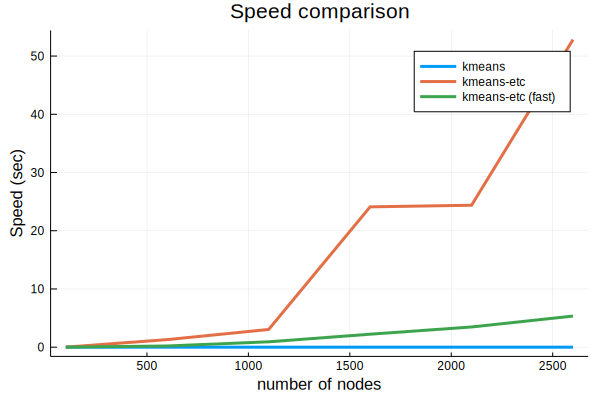

In [24]:
plt = plot(models, [kmeans_speed kmeans_etc_speed kmeans_etc_fast_speed],
    xlabel="number of nodes", ylabel="Speed (sec)", title="Speed comparison",
    label=["kmeans" "kmeans-etc" "kmeans-etc (fast)"], width=3)
display(plt)
savefig(plt, "./figures/speed.png")

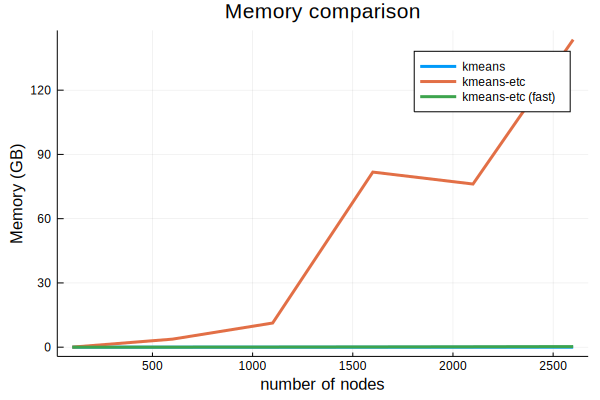

In [15]:
plt = plot(models, [kmeans_memory kmeans_etc_memory kmeans_etc_fast_memory],
    xlabel="number of nodes", ylabel="Memory (GB)", title="Memory comparison",
    label=["kmeans" "kmeans-etc" "kmeans-etc (fast)"], width=3)
display(plt)
savefig(plt, "./figures/memory.png")